<a href="https://colab.research.google.com/github/gvogiatzis/CS4740/blob/main/CS4740_Lab_Week_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS4740 Labs
## Week 3 - Networks in Pytorch

In this lab we will be continuing with our exploration of Deep Learning and Pytorch by carrying out some more classification experiments, this time in image data. 

The MNIST dataset, created almost 30 years ago, is one of the most commonly used machine learning datasets. It consists of 60,000 tiny images (28x28) of handwritten digits that must be correctly classified into one of 10 classes. Widely considered as the "hello world" equivalent for ML researchers, it is the go-to dataset for any new algorithm that is proposed for image classification and ML in general. As the old saying goes, "If it doesn't work on MNIST, it won't work at all". 

![alt text](https://www.researchgate.net/profile/Steven_Young11/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Just to be different, and a little more ambitious, we will be using a more recent and significantly more challenging dataset, known as KMNIST, that consists of 28x28 images of handwritten Japanese kuzushiji (18th c. cursive calligraphy) characters (10 classes out of the possible 49).

![alt text](http://codh.rois.ac.jp/img/kmnist.png)

The image above shows examples from the ten classes in the dataset with the first collumn representing the modern Hiragana printed version. See this [paper](https://arxiv.org/pdf/1812.01718.pdf) for more technical details. More about the fascinating history of kuzushiji [here](http://naruhodo.weebly.com/blog/introduction-to-kuzushiji)

# Section 1. Loading up the dataset

Fortunately for us, Pytorch already comes with utility classes for downloading and using a whole host of interesting ML datasets under the `torchvision.datasets` module. Let's begin by downloading both the training and test subsets of the KMNIST dataset.

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

train_dataset = torchvision.datasets.KMNIST('.', train=True, download=True,
                             transform=torchvision.transforms.ToTensor())

test_dataset = torchvision.datasets.KMNIST('.', train=False, download=True,
                             transform=torchvision.transforms.ToTensor())


Extracting ./KMNIST/raw/train-images-idx3-ubyte.gz to ./KMNIST/raw



Extracting ./KMNIST/raw/train-labels-idx1-ubyte.gz to ./KMNIST/raw



Extracting ./KMNIST/raw/t10k-images-idx3-ubyte.gz to ./KMNIST/raw



Extracting ./KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./KMNIST/raw
Processing...
Done!


The `KMNIST` helper function can be conveniently supplied with a transform object that can be used to perform all kinds of operation on a datapoint prior to its use. We can apply dataset normalization, data augmentation , image cropping, histogram equalization etc. Here we use the `ToTensor` to transform PIL images into pytorch tensors. 

Each datapoint will consist of a pair of image (converted into a tensor) and a number from 0 to 9 corresponding to class. Let's display a sample image with its target class.

7


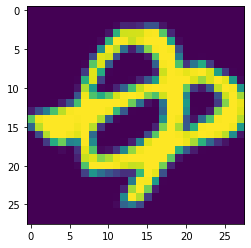

In [ ]:
img, target = train_dataset[999]
plt.imshow(img.squeeze())
print(target)

Last week we applied Logistic Regression to some very simple data and we learned how to use direcly some torch layers such as `torch.nn.Linear`. This time we will see how to package everything into a single network object. This provides a number of benefits such as, automatically extracting the list of all model parameters (for optimization) or moving the whole network on to the GPU.

## Section 2. Creating a network

To create your own neural network architecture you must subclass the torch.nn.Module class. This involves writting a constructor, where all the member variables are defined and initialized, and overload the .forward() method which describes how the network input is transformed to the output. The beauty of Pytorch is that it then handles the .backward() method automatically (details in lecture). Let's write a simple logistic regression network, to warm us up.

In [ ]:
class LogisticNet(nn.Module):
    def __init__(self):
        super(LogisticNet, self).__init__()
        self.fc = nn.Linear(784, 10)
        
    def forward(self, x):
        x = x.view(-1,784)
        x = self.fc(x)
        return F.log_softmax(x,dim=1)
        return x

lognet = LogisticNet()

Note that the line 
```
x = x.view(-1,784)
```
has the effect of **flattening** the image into a vector of 28x28=784 elements.

And that's it! In 8 lines of code (most of which is boilerplate anyway) you've programmed your first neural network. Its weights have also been conveniently initialized so let's give it a spin on an actual datapoint.

In [ ]:
img, target = train_dataset[999]

print(torch.exp(lognet(img)))

tensor([[0.0806, 0.1250, 0.1107, 0.1147, 0.0784, 0.1040, 0.0890, 0.0741, 0.0952,
         0.1283]], grad_fn=<ExpBackward>)


These are the probabilities that our network assigns to each of the ten classes for this datapoint. Note that the network outputs log-probabilities because of better numerics so to get to an actual distribution we must exponentiate. Of course we haven't done any training yet so the numbers are random. So let's write some training code. This will take the, by now familiar pattern of forward step, loss function calculation, backward step. The only difference is that we will be using mini-batches. See lecture for more details but mini-batch training means we will be updating the network weights by computing the loss function (and its gradient) on small subsets of the dataset, usually around 64 datapoints at a time.

## Section 3. Training and testing

It is very good to get into the habit of using the torch.utils.data.DataLoader to help with randomly shuffling the data, splitting it into mini-batches as well as optimizing the concurrent data access with number crunching code. The call to the dataloader constructor looks as follows:

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1000, shuffle=True)

The dataloader objects are accessed through iterators and they iterate through every minibatch. To get the very first minibatch of images and targets we would do

In [ ]:
x, t = next(iter(train_loader))

In [ ]:
print(x.shape)
print(t.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


So the data minibatch consists of 64 images. Let's define a standard negative log likelihood loss function and evaluate it on this data/target mini-batch. Now most pytorch layers (Linear, Conv, MaxPool etc) are clever enough to be applied on a minibatch, i.e. on all tensor dimensions except the minibatch dimension which is the first one. Loss functions on the other hand will be reduced (by averaging or summing) across the mini-batch to a single scalar. We will then call `.backward()` on that.

In [ ]:
loss = nn.NLLLoss()
print(loss(lognet(x),t))

tensor(2.3442, grad_fn=<NllLossBackward>)


Let's also create an SGD optimizer object as in the previous lab, with a learning rate of 0.01 and momentum parameter=0.5

In [ ]:
optim_SGD = optim.SGD(lognet.parameters(), lr=0.01, momentum=0.5)

We can now write our training routine. You will find a variant of this code snippet in essentially all pytorch code you ever come across. 

In [ ]:
def train(net,dataloader, optimizer,loss_fun):
  net.train()
  for x, t in dataloader:
    optimizer.zero_grad()
    L = loss_fun(net(x), t)
    L.backward()
    optimizer.step()

But before running this, we need to make sure we evaluate the performance of our model on the test dataset

In [ ]:
def test(net,dataloader,loss_fun):
  net.eval()
  total_L = 0
  correct = 0
  with torch.no_grad():
    for x, t in dataloader:
      out = net(x)
      total_L += loss_fun(out, t)
      _,pred = out.max(dim=1)     # this counts how many we got right
      correct += (pred==t).sum() 
  total_L /= len(dataloader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    total_L, correct, len(dataloader.dataset),
    100. * correct / len(dataloader.dataset)))

The test code contains essentially only the forward part of the computation. We will be applying it onto the test dataset and with a loss function that does not average, so we can sum it across the whole dataset. The only other difference is that we can use a much bigger mini-batch size because we don't have to worry about the memory-intensive backward step.

If we test the performance of the network now, before any training, it should be roughly on 10% (i.e. random correct prediction of 10 classes)

In [ ]:
print("Testing before any training ...")
test(lognet, test_loader,  nn.NLLLoss(reduction='sum'))

Testing before any training ...

Test set: Avg. loss: 2.3309, Accuracy: 1119/10000 (11%)




Let us now do a few train-test iterations, or **epochs** as they are known in the trade:

In [ ]:
for e in range(10):
  print(f"Epoch: {e+1}/10. Training ...")
  train(lognet, train_loader, optim_SGD, nn.NLLLoss())
  print("Testing ...")
  test(lognet, test_loader,  nn.NLLLoss(reduction='sum'))  

What performance did you manage to get? You should find that it usually tails off at around 70%. That is definitely better than random but not terribly good. Let us try a different network that includes one hidden layer with a ReLU activation (rectified linear unit, whose response is given by y=max(0,x) )

In [ ]:
class MLPNet(nn.Module):
    def __init__(self, hidden_size):
        super(MLPNet, self).__init__()        
        self.fc1 = nn.Linear(784, hidden_size)
        self.fc2 = nn.Linear(hidden_size,10)

        
    def forward(self, x):
        x = x.view(-1,784)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)
        return x

mlpnet = MLPNet(256)

optim_SGD = optim.SGD(mlpnet.parameters(), lr=0.01, momentum=0.5)

Let's train and test as before.

In [ ]:
print("Testing before any training ...")
test(mlpnet, test_loader,  nn.NLLLoss(reduction='sum'))

for e in range(20):
  print(f"Epoch: {e+1}/20. Training ...")
  train(mlpnet, train_loader, optim_SGD, nn.NLLLoss())
  print("Testing ...")
  test(mlpnet, test_loader,  nn.NLLLoss(reduction='sum'))  

Testing before any training ...

Test set: Avg. loss: 2.3012, Accuracy: 1164/10000 (12%)

Epoch: 1/20. Training ...
Testing ...

Test set: Avg. loss: 1.0741, Accuracy: 6664/10000 (67%)

Epoch: 2/20. Training ...
Testing ...

Test set: Avg. loss: 0.9222, Accuracy: 7103/10000 (71%)

Epoch: 3/20. Training ...
Testing ...

Test set: Avg. loss: 0.8170, Accuracy: 7409/10000 (74%)

Epoch: 4/20. Training ...
Testing ...

Test set: Avg. loss: 0.7603, Accuracy: 7601/10000 (76%)

Epoch: 5/20. Training ...
Testing ...

Test set: Avg. loss: 0.7046, Accuracy: 7789/10000 (78%)

Epoch: 6/20. Training ...
Testing ...

Test set: Avg. loss: 0.6787, Accuracy: 7867/10000 (79%)

Epoch: 7/20. Training ...
Testing ...

Test set: Avg. loss: 0.6320, Accuracy: 8024/10000 (80%)

Epoch: 8/20. Training ...
Testing ...

Test set: Avg. loss: 0.6129, Accuracy: 8106/10000 (81%)

Epoch: 9/20. Training ...
Testing ...

Test set: Avg. loss: 0.5885, Accuracy: 8177/10000 (82%)

Epoch: 10/20. Training ...
Testing ...

Test s

Your performance should now be edging towards 90%. Nice! 

But is it possible to shed some more light as to how the network is performing its computation? Actually in shallow networks such as our MLP, we can sometimes visualize what is going on at least in the first layer, by rendering the weights as images. These weights are essentially patterns that the network is trying to match in the input image. We can access the weights of the first layer `fc1` and use the `.view` method to reshape them into a sequence of 28x28 images. 

In [ ]:
filters = mlpnet.fc1.weight.view(-1, 28, 28).detach()

We can then use the `make_grid` command from the `torchvision.utils` module to create a MxN grid of images. Just render them with the `imshow` command in `matplotlib`.

In [ ]:
from torchvision.utils import make_grid

grid=make_grid(filters[0:50,None,:,:], nrow=10,normalize=True)
plt.imshow(grid.permute(1,2,0),)

We can definitely observe some faint patterns corresponding to some of those hiragana script characters. These patterns are the basic level **decisions** that the network is making in the first layer. The output of those decisions is then fed to subsequent layers for more high-level processing until at the end the network is able to infer the class of the input image.

## Section 4. Challenges


1.   By modifying the mlpnet, can you try a network with two or more hidden layers?
2.   Can modify the testing code so that it prints out more detailed error analysis? E.g. accuracy per class, topK  etc) 
3.   In a similar vein, can you compute a confusion matrix? I.e. can you count the number of datapoints that belonged to class a, and were classified as class b, for a,b in 0,1,2,...,10 ?
4. Can you try other datasets in pytorch? You can directly drop in MNIST (run `torchvision.datasets.MNIST`) which has same resolution images but for extra challenge, can you apply your algorithm on CIFAR-10? (run `torchvision.datasets.CIFAR10`) That dataset contains 60,000 color images of 32x32 resolution (so the shape of each image is 3x32x32)

